In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

locations_df = pd.read_csv("csv-locations_12.9514242_77.6590212.csv")
routes_df = pd.read_csv("csv-routes.csv")
df = pd.read_csv("csv-bangalore_traffic.csv")

![routes.png](routes.png)

In [124]:
display(df.describe())
display(df.describe(exclude='number'))
display(df['route_code'].value_counts())

,duration,distance
count,291.000000,291.000000
mean,29.769759,11.585911
std,10.453769,5.548629
min,14.000000,9.400000
25%,21.000000,9.900000
50%,29.000000,10.200000
75%,37.000000,10.600000
max,75.000000,34.800000


,date,time,route_code
count,291,291,291
unique,2,25,12
top,2025-09-26,14:25,2HM2+P8|XJV5+RG
freq,175,12,25


route_code
2HM2+P8|XJV5+RG     25
VJRQ+2M|RMJJ+F4     25
WH5F+26|WJ8X+F5W    25
XJPW+92|WJP4+FF     25
2HVW+G8|XJXR+WG     25
XHFC+WMF|WGGC+MG    25
XPC7+72|XM33+J3     25
WHCJ+26|XGCP+FV     25
XMW9+G8|WMJR+V4     25
XHJ7+MG|WJM6+VC     25
WHR9+R6|XJGF+6J     25
XJG4+7J|5PX4+HQ     16
Name: count, dtype: int64

In [125]:
# Process traffic data
df_traffic = df.copy()
df_traffic['year'] = pd.to_datetime(df_traffic['date']).dt.year
df_traffic['month'] = pd.to_datetime(df_traffic['date']).dt.month
df_traffic['date'] = pd.to_datetime(df_traffic['date']).dt.day
df_traffic['hour'] = pd.to_datetime(df_traffic['time'], format='%H:%M', errors='coerce').dt.hour
df_traffic['avg_speed'] = round(df_traffic['distance'] / (df_traffic['duration'] / 60), 2)
df_traffic['origin'] = df_traffic['route_code'].str.split('|').str[0]
df_traffic['destination'] = df_traffic['route_code'].str.split('|').str[1]
df_traffic['origin'] = df_traffic['origin'].map(locations_df.set_index('plus_code')['location'])
df_traffic['destination'] = df_traffic['destination'].map(locations_df.set_index('plus_code')['location'])
df_traffic = df_traffic[['year', 'month', 'date', 'hour', 'origin', 'destination', 'duration', 'distance', 'avg_speed']]
df_traffic = df_traffic.sort_values(['year', 'month', 'date', 'hour', 'duration'], ascending=[True, True, True, True, True]).reset_index(drop=True)
display(df_traffic.tail(15))

,year,month,date,hour,origin,destination,duration,distance,avg_speed
276,2025,9,26,14,"RV Road Metro Station, Jayanagar 5th Block","Vijayanagar Metro Station, Chord Road",37,10.8,17.51
277,2025,9,26,14,"Big Bull Temple, Basavanagudi","Shri Someshwara Swamy Temple, Halasuru",39,10.1,15.54
278,2025,9,26,14,MG Road Metro Station,"Kempegowda International Airport, Bengaluru",56,34.3,36.75
279,2025,9,26,15,Kudlu Gate Metro Station,Biocon Campus,22,10.3,28.09
280,2025,9,26,15,Benniganahalli Metro Station,"Embassy TechVillage, Devarabisanahalli",23,10.1,26.35
281,2025,9,26,15,Jaya Prakash Nagar Metro Station,"Hemavathi Park, HSR Layout",24,10.2,25.50
282,2025,9,26,15,The Rameshwaram Cafe @ Brookfield,"Gawky Goose, Wind Tunnel Rd",28,9.4,20.14
283,2025,9,26,15,Jaya Prakash Narayana Park,"Coles Park, Fraser Town",31,10.2,19.74
284,2025,9,26,15,"Bethel AG Church, Hebbal",SMVT Railway Station,34,9.9,17.47
285,2025,9,26,15,Swami Vivekananda Road Metro Station,"Christ University, Hosur Main Road",37,10.7,17.35


In [126]:
# Build timestamps from the loaded traffic_df
df['ts'] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
df = df.dropna(subset=['ts']).sort_values('ts')

# Last 24h window relative to the dataset’s latest timestamp
end = df['ts'].max()
start = end - pd.Timedelta(hours=24)
df_24 = df[(df['ts'] >= start) & (df['ts'] <= end)].copy()

# Human-readable labels from locations CSV
loc_path = "csv-locations_12.9514242_77.6590212.csv"
loc_map = pd.read_csv(loc_path).set_index("plus_code")["location"].to_dict()

def label_for_route(route_code: str) -> str:
    try:
        o, d = route_code.split("|", 1)
    except ValueError:
        return route_code
    o_name = loc_map.get(o, o)
    d_name = loc_map.get(d, d)
    return f"{o_name} \u2192 {d_name}"  # → arrow

# Build a common timeline (all observed timestamps in the window)
timeline = pd.Index(sorted(df_24['ts'].unique()))

# Helper: neighbor-mean fill for a single route frame indexed by 'ts'
# - Fill duration by neighbor mean
# - Carry distance via ffill/bfill
def fill_route(frame_idx_ts: pd.DataFrame, route_code: str) -> pd.DataFrame:
    g = frame_idx_ts.reindex(timeline)

    # Keep route_code + distance
    g['route_code'] = g['route_code'].ffill().bfill()
    if g['route_code'].isna().all():
        g['route_code'] = route_code

    # Distance: carry forward/back; assume stable per route per timestamp
    g['distance'] = pd.to_numeric(g['distance'], errors='coerce')
    g['distance_filled'] = g['distance'].ffill().bfill()

    # Duration: neighbor-mean fill
    durations = pd.to_numeric(g['duration'], errors='coerce')
    prev_vals = durations.ffill()
    next_vals = durations.bfill()
    filled = durations.copy()

    mask_missing = durations.isna()
    mask_both = mask_missing & prev_vals.notna() & next_vals.notna()
    filled.loc[mask_both] = (prev_vals.loc[mask_both] + next_vals.loc[mask_both]) / 2.0

    mask_prev_only = mask_missing & prev_vals.notna() & next_vals.isna()
    mask_next_only = mask_missing & next_vals.notna() & prev_vals.isna()
    filled.loc[mask_prev_only] = prev_vals.loc[mask_prev_only]
    filled.loc[mask_next_only] = next_vals.loc[mask_next_only]

    g['duration_filled'] = filled

    # Average speed (km/h) = 60 * distance_km / duration_min
    dur_safe = g['duration_filled'].replace(0, pd.NA)
    g['speed_kmph'] = 60.0 * g['distance_filled'] / dur_safe
    return g.reset_index(names='ts')

# Process each route explicitly (no groupby.apply to avoid warnings)
frames = []
for route in sorted(df_24['route_code'].unique()):
    r = df_24.loc[df_24['route_code'] == route, ['ts', 'route_code', 'duration', 'distance']].set_index('ts')
    frames.append(fill_route(r, route))

df_filled = pd.concat(frames, ignore_index=True).sort_values(['ts', 'route_code'])
df_filled['label'] = df_filled['route_code'].apply(label_for_route)

# Smooth/curvy lines on speed
def smooth_series(ts: pd.Series, ys: pd.Series) -> pd.Series:
    mask_valid = ys.notna()
    ts_valid = ts[mask_valid]
    ys_valid = ys[mask_valid]

    if len(ys_valid) < 3:
        return ys

    try:
        from scipy.interpolate import PchipInterpolator
        x = ts_valid.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
        y = ys_valid.to_numpy(dtype=float)
        x_all = ts.map(pd.Timestamp.toordinal).to_numpy(dtype=float)
        interp = PchipInterpolator(x, y)
        return pd.Series(interp(x_all), index=ts)
    except Exception:
        # Fallback: centered rolling mean
        win = 3 if len(ys_valid) < 10 else 5
        return ys.rolling(window=win, center=True, min_periods=1).mean()

# Create a 1D Series aligned to df_filled.index without groupby.apply
speed_smooth = pd.Series(index=df_filled.index, dtype=float)
for label, idx in df_filled.groupby('label').groups.items():
    g = df_filled.loc[idx]
    y_smooth = smooth_series(g['ts'], g['speed_kmph'])
    speed_smooth.loc[idx] = y_smooth.values

df_filled['speed_smooth'] = speed_smooth

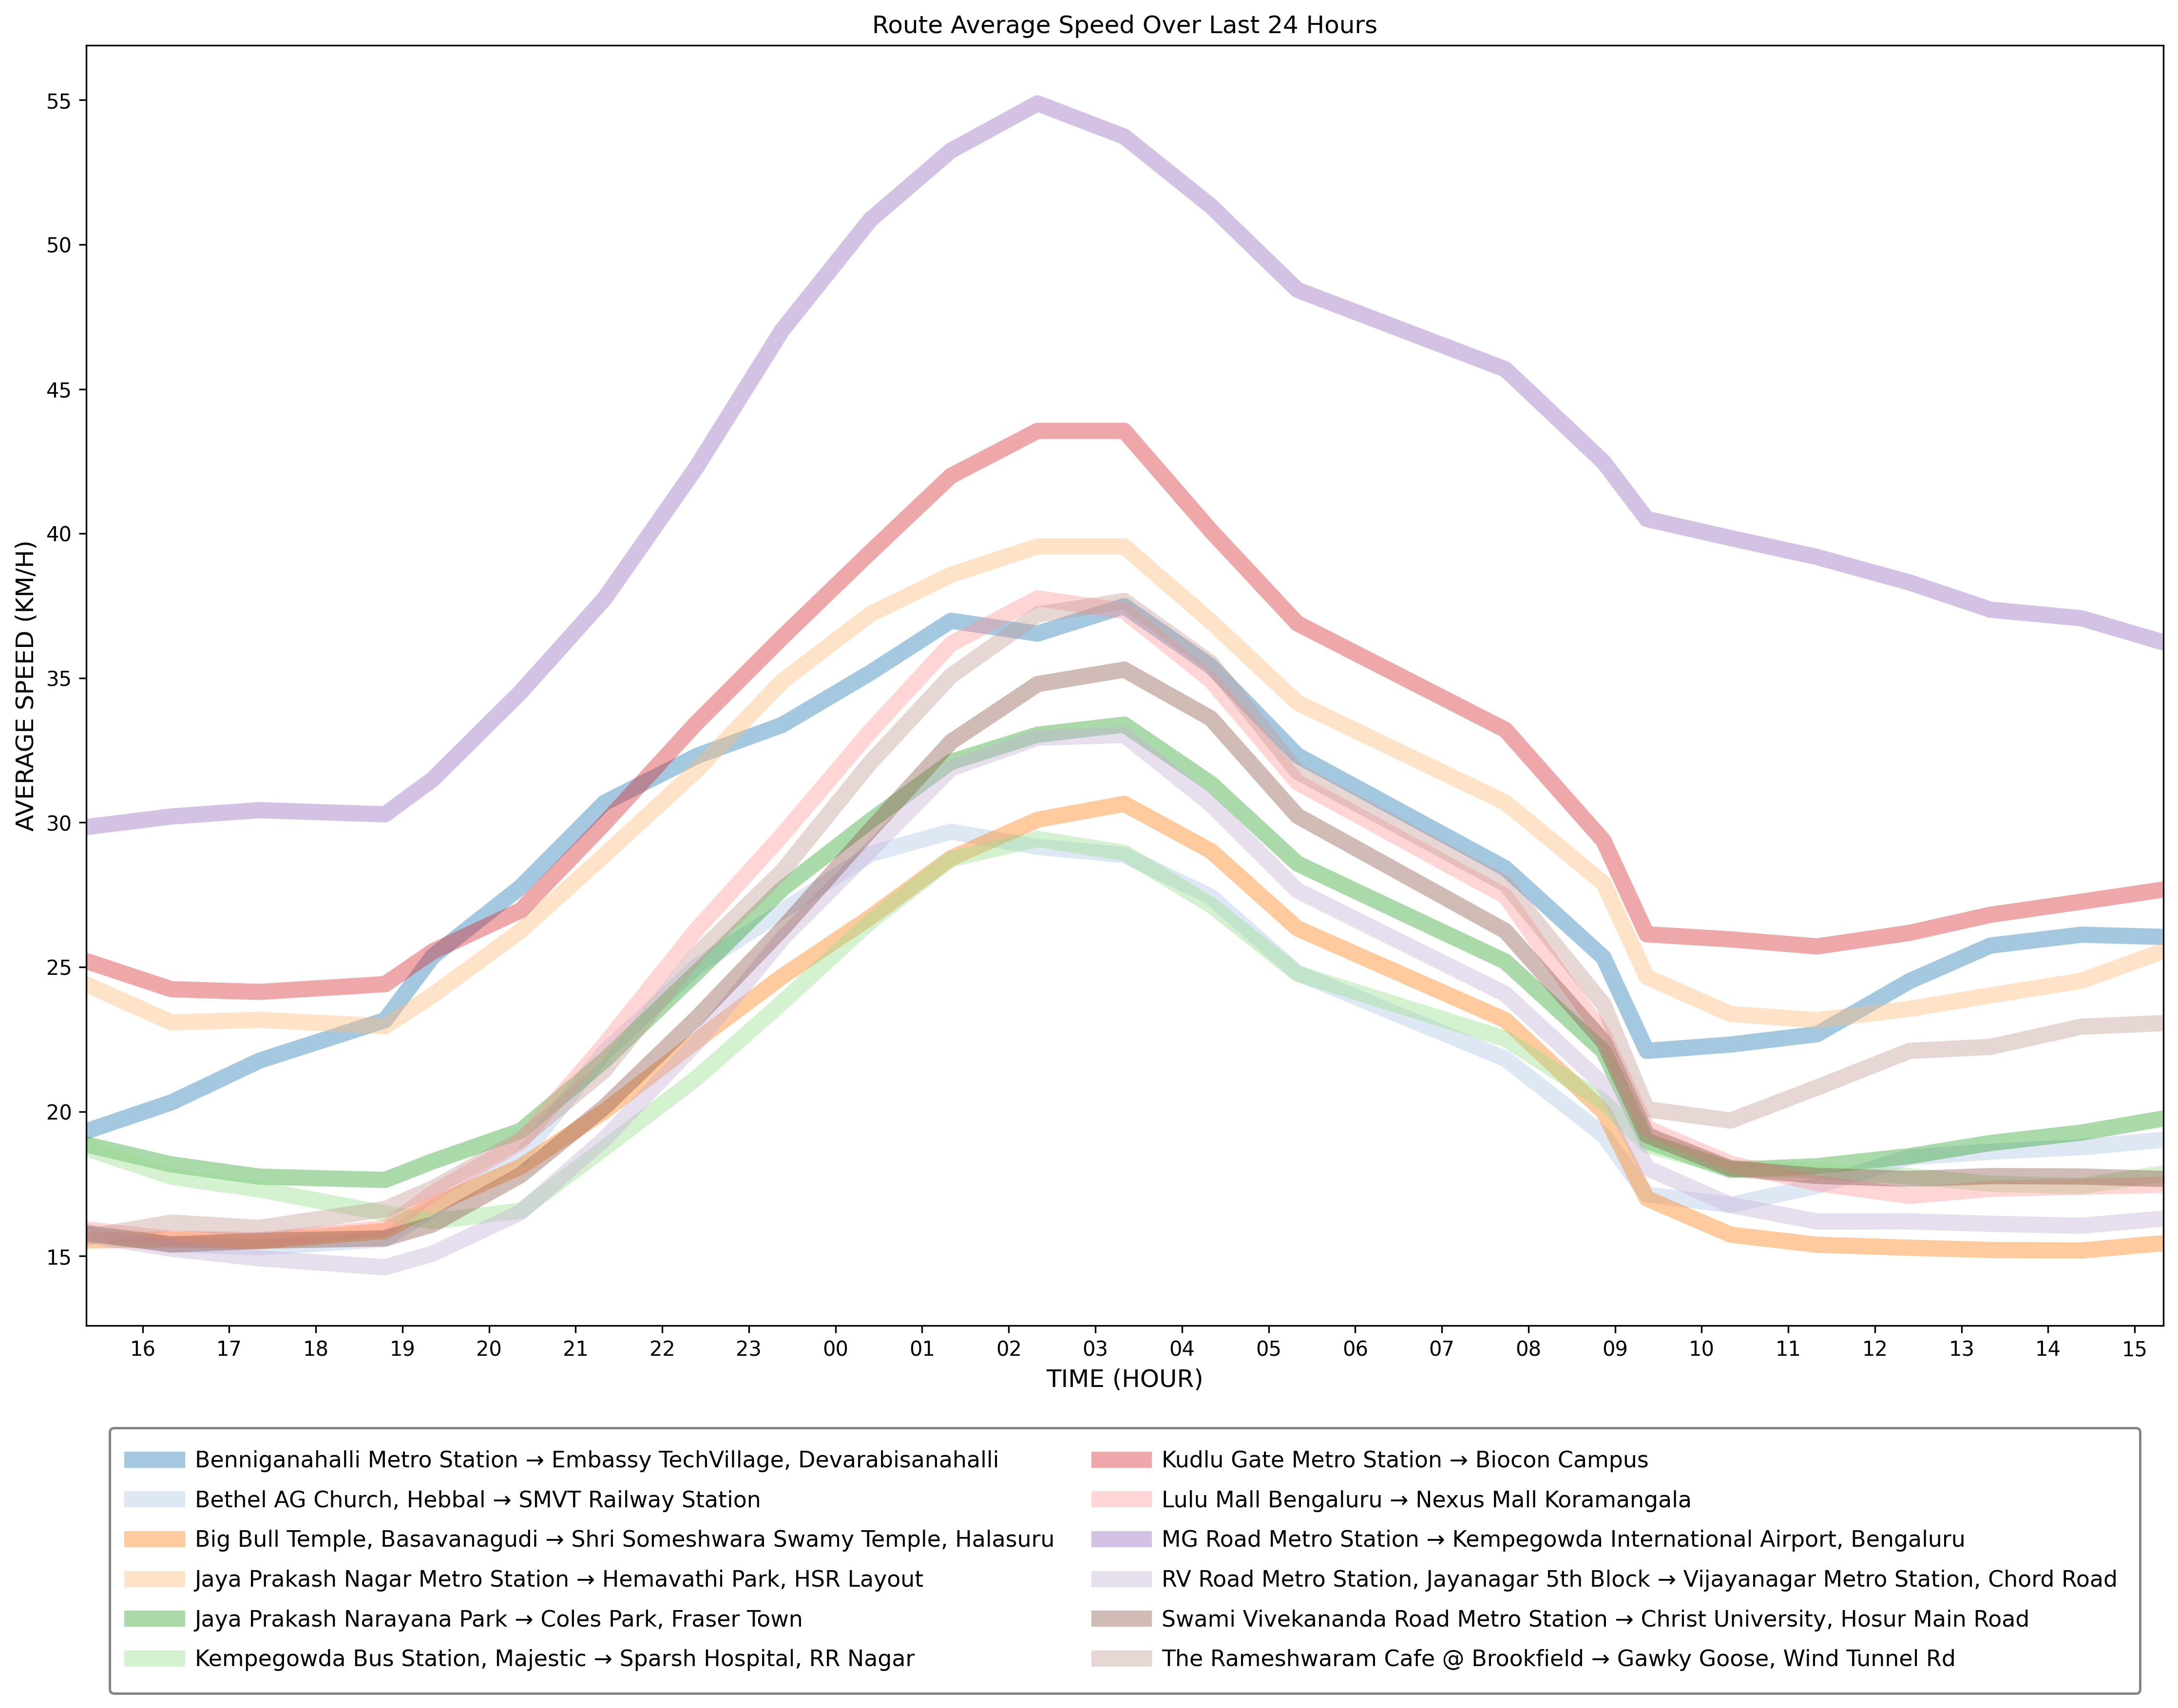

In [127]:
# Plot: average speed, legend outside (or move below), HH-only x-axis
hue_order = sorted(df_filled['label'].unique())
palette = sns.color_palette("tab20", n_colors=len(hue_order))

fig, ax = plt.subplots(figsize=(16, 12), dpi=300)
sns.lineplot(
    data=df_filled,
    x='ts', y='speed_smooth',
    hue='label',
    hue_order=hue_order,
    palette=palette,
    ax=ax,
    linewidth=8, alpha=0.4
)
ax.margins(x=0)  # remove automatic horizontal padding
ax.set_xlim(df_filled['ts'].min(), df_filled['ts'].max())

# X-axis as hours only (HH)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
ax.set_xlabel('Time (Hour)'.upper(), fontsize=12)
ax.set_ylabel('Average Speed (km/h)'.upper(), fontsize=12)
ax.set_title('Route Average Speed Over Last 24 Hours')

# Legend outside on the bottom:
handles, labels = ax.get_legend_handles_labels()
leg = ax.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.08),  # keep your preferred anchor
    ncol=2,
    frameon=True,
    borderaxespad=0.0,
    fontsize=11,
    borderpad=1.0,     # inner frame padding
    labelspacing=0.8   # spacing between legend entries
)
leg.get_frame().set_linewidth(1.2)
leg.get_frame().set_edgecolor('#666')
plt.tight_layout()
plt.subplots_adjust(bottom=0.24)
plt.show()

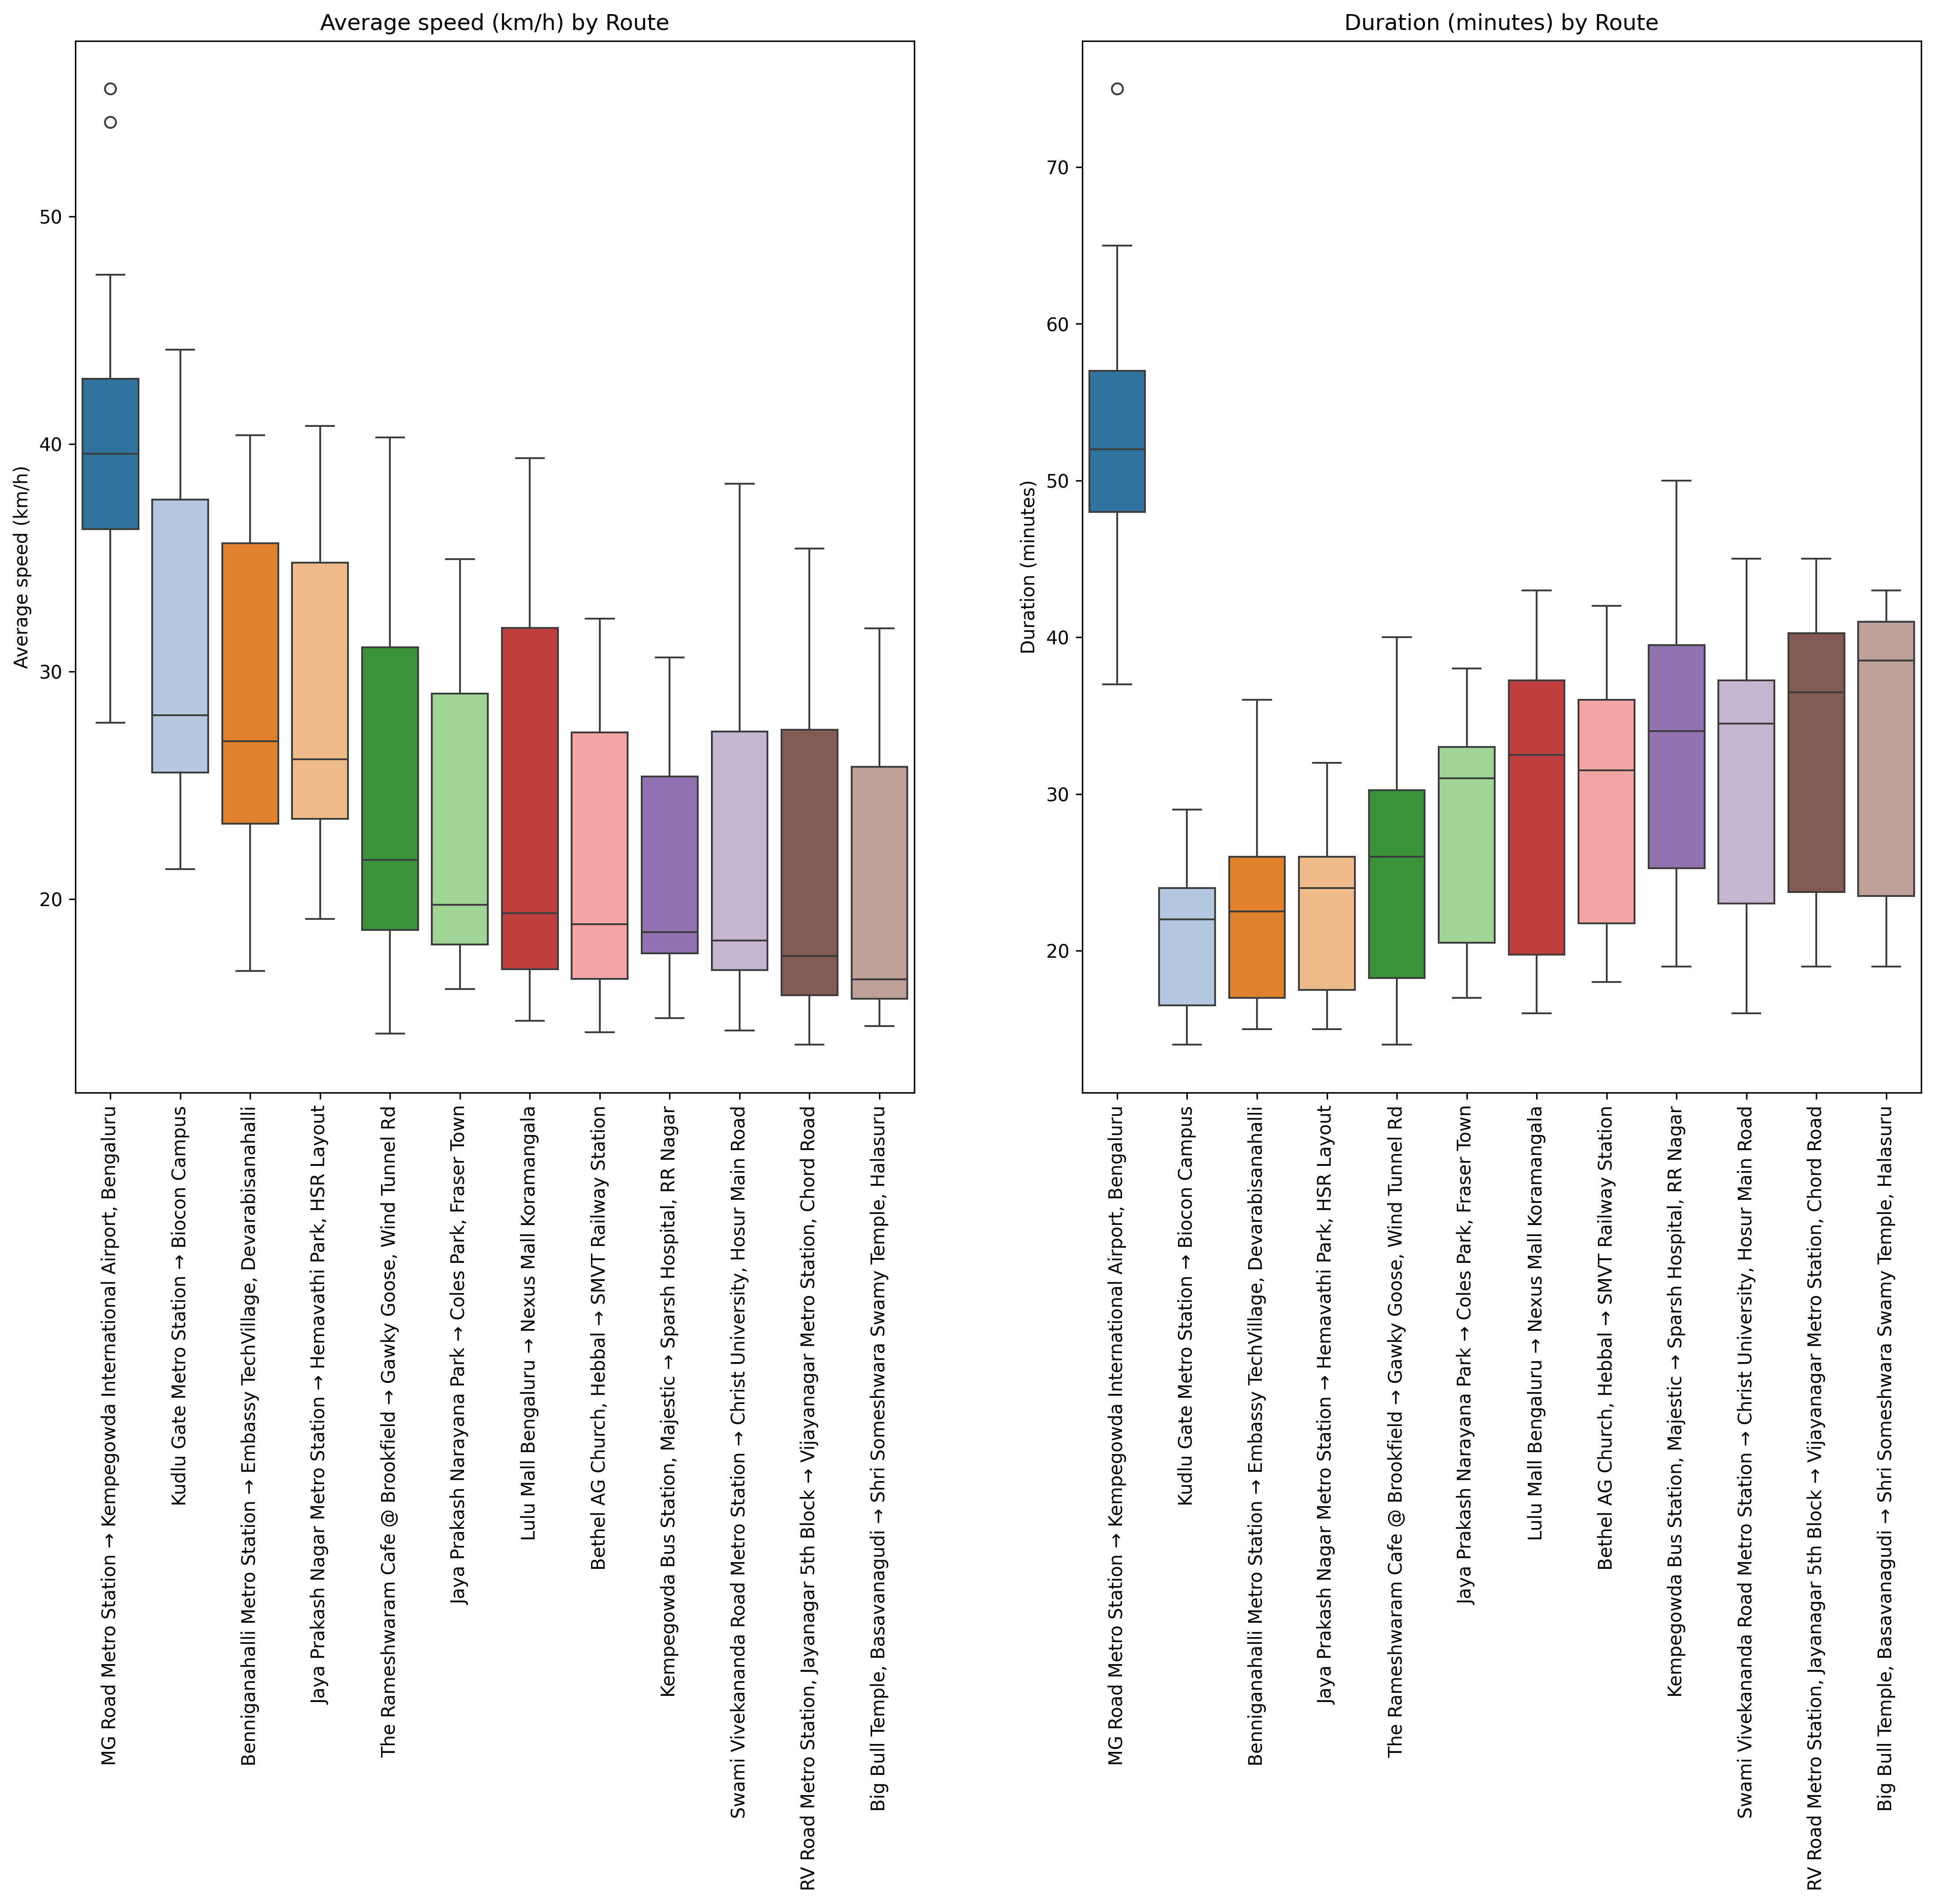

In [128]:
# Boxplots for duration, distance, and average speed per route
df_box = df_filled.copy()
df_box['ts'] = pd.to_datetime(df_box['ts'], errors='coerce')
df_box = df_box.dropna(subset=['ts'])

# Human-readable labels
loc_map = (
    pd.read_csv("csv-locations_12.9514242_77.6590212.csv")
      .set_index("plus_code")["location"]
      .to_dict()
)

def label_for_route(code: str) -> str:
    try:
        origin_code, dest_code = code.split("|", 1)
    except ValueError:
        return code
    origin = loc_map.get(origin_code, origin_code)
    dest = loc_map.get(dest_code, dest_code)
    return f"{origin} \u2192 {dest}"

df_box['label'] = df_box['route_code'].map(label_for_route)

# Average speed (km/h)
df_box['avg_speed'] = 60.0 * df_box['distance'] / df_box['duration'].replace(0, pd.NA)

metrics = [
    ('avg_speed', 'Average speed (km/h)'),
    ('duration', 'Duration (minutes)')
]

# Sort routes by median duration (ascending)
route_order = (
    df_box.groupby('label')['avg_speed']
          .median()
          .sort_values(ascending=False)
          .index.tolist()
)

fig, axes = plt.subplots(1, len(metrics), figsize=(18, 15), sharex=False, dpi=300)

for ax, (metric, ylabel) in zip(axes, metrics):
    sns.boxplot(
        data=df_box,
        x='label',
        y=metric,
        hue='label',                # tie palette to hue to silence warning
        order=route_order,
        hue_order=route_order,
        palette='tab20',
        dodge=False,
        legend=False,
        ax=ax
    )
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    ax.set_title(f'{ylabel} by Route')
    ax.tick_params(axis='x', rotation=90)

    if ax.legend_:
        ax.legend_.remove()

plt.subplots_adjust(bottom=0.35)
plt.show()